    LSTM Network:

Time series analysis to predict Facebook's daily stock price using an LSTM model

In [29]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM

os.chdir('/Users/tomkuhle/OneDrive/Documents/Programming/facebook_LSTM/')

    Import data:

Import daily facebook share prices.

Subset the `Close` column for modelling.

In [44]:
def import_data():
    
    data = pd.read_csv("facebook_day.csv", index_col = 'Local Time')
    data = data[['Close']]
    return data

input_data = import_data()

print(input_data.head())

                                   Close
Local Time                              
25.01.2017 22:00:00.000 GMT-0000  132.74
26.01.2017 22:00:00.000 GMT-0000  132.11
27.01.2017 22:00:00.000 GMT-0000  132.11
28.01.2017 22:00:00.000 GMT-0000  132.11
29.01.2017 22:00:00.000 GMT-0000  130.92


    Plot data:

Plot the closing price

<Figure size 2400x1200 with 0 Axes>

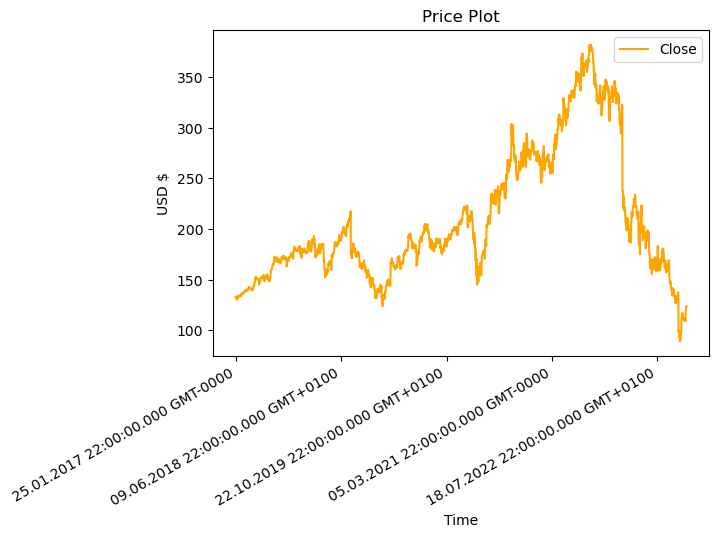

In [45]:
def plot_data(data):
    
    plt.style.use('default')
    %matplotlib inline

    plt.figure(figsize=(16, 8), dpi=150)
    data.plot(label='Price', color='orange')
    plt.title('Price Plot')
    plt.xlabel('Time')
    plt.ylabel('USD $')
    plt.gcf().autofmt_xdate()
    plt.legend()
    
    pass

plot_data(input_data)

    Pre-processing:

Scale the data between 0 and 1 for the model input.

Find the log of the data to get a more stationary dataset.

In [46]:
def preprocessing(data):
    
    data_matrix = np.array(data)
    
    np.seterr(divide = 'ignore')
    log_values = np.where(data_matrix != 0, np.log(data_matrix), 0)
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(log_values)
    
    return scaled_data, scaler

preprocessed_data, scaler_min_max = preprocessing(input_data)

print(preprocessed_data[:5])

[[0.27507532]
 [0.27181299]
 [0.27181299]
 [0.27181299]
 [0.26560814]]


In [47]:
class TrainValidTestSplit:
    """
    a class to split the training, validation and testing data
    """
    
    def __init__(self, preprocessed_data, training_proportion, validation_proportion, sequence_length):
        
        self.preprocessed_data = preprocessed_data
        self.training_proportion = training_proportion
        self.validation_proportion = validation_proportion
        self.sequence_length = sequence_length
        self.training_data_len = int(
            np.ceil( 
            len(preprocessed_data) * training_proportion 
            )
        )
        self.validation_data_len = int(
            np.ceil( 
                len(preprocessed_data) * validation_proportion 
            )
        )

    
    def training_split(self):

        train_data = self.preprocessed_data[
            0:self.training_data_len, :
        ]
        x_train = []
        y_train = []

        for i in range(self.sequence_length, len(self.preprocessed_data)):
            x_train.append(
                self.preprocessed_data[i-self.sequence_length:i, 0]
            )
            y_train.append(
                self.preprocessed_data[i, 0]
            )

        x_train, y_train = np.array(x_train), np.array(y_train)

        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        
        return x_train, y_train

    
    def validation_split(self):
        
        validation_data = self.preprocessed_data[
            self.training_data_len : self.training_data_len + self.validation_data_len,
            :
        ]
        x_validation = []
        y_validation = []

        for i in range(self.sequence_length, len(validation_data)):
            x_validation.append(validation_data[i-self.sequence_length:i, 0])
            y_validation.append(validation_data[i, 0])

        x_validation, y_validation = np.array(x_validation), np.array(y_validation)

        x_validation = np.reshape(x_validation, (x_validation.shape[0], x_validation.shape[1], 1))
        
        return x_validation, y_validation

    
    def testing_split(self):
        
        test_data = self.preprocessed_data[
            self.training_data_len + self.validation_data_len - self.sequence_length :, 
            :
        ]
        x_test = []
        y_test = self.preprocessed_data[
            self.training_data_len + self.validation_data_len :,
            :
        ]

        for i in range(self.sequence_length, len(test_data)):
            x_test.append(test_data[i-self.sequence_length:i, 0])

        x_test = np.array(x_test)

        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

        return x_test, y_test

# instantiate the class
train_valid_test_split = TrainValidTestSplit(
    preprocessed_data,
    training_proportion=0.8, 
    validation_proportion=0.1, 
    sequence_length = 35
)

x_train, y_train = train_valid_test_split.training_split()
x_validation, y_validation = train_valid_test_split.validation_split()
x_test, y_test = train_valid_test_split.testing_split()

    LSTM Model:

define LSTM model object.

use the keras Sequential class to build a model with an optional number of stacked layers of nodes. two layers of nodes will provide an adequate number of parameters to predict the share price. we must return the sequence of the first layer due to the recurrent network.

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 35, 64)            16896     
                                                                 
 lstm_15 (LSTM)              (None, 32)                12416     
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
22/22 [==============================] - 5s 97ms/step - loss: 0.0455 - val_loss: 0.0515
Epoch 2/20
22/22 [==============================] - 2s 75ms/step - loss: 0.0386 - val_loss: 0.0542
Epoch 3/20
22/22 [==============================] - 3s 141ms/step - loss: 0.0379 - val_loss: 0.0609
Epoch 4/20
22/22

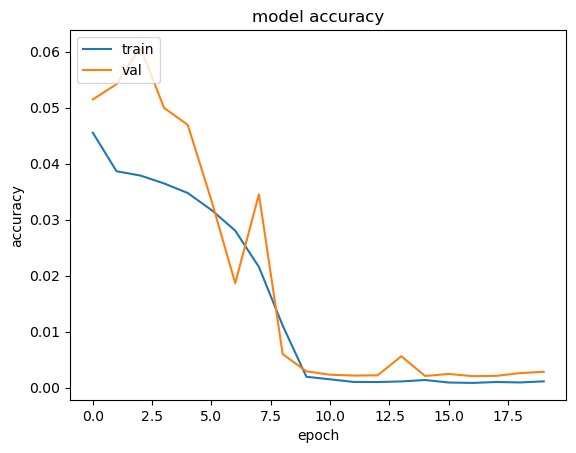

In [57]:
class LstmModel:
    
    def __init__(self, 
                 x_train, 
                 y_train, 
                 x_validation, 
                 y_validation, 
                 first_layer_nodes,
                 second_layer_nodes, 
                 batch_size, 
                 epochs):
        
        self.x_train=x_train
        self.y_train=y_train
        self.x_validation=x_validation
        self.y_validation=y_validation
        self.first_layer_nodes=first_layer_nodes
        self.second_layer_nodes=second_layer_nodes
        self.batch_size=batch_size
        self.epochs=epochs
        
    def model(self):
    
        model = Sequential()
        model.add(LSTM(
            self.first_layer_nodes, 
            activation='sigmoid', 
            return_sequences=True, 
            input_shape=(self.x_train.shape[1], 1)))
        model.add(LSTM(
            self.second_layer_nodes, 
            activation='sigmoid'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        model.summary()

        history = model.fit(x=self.x_train,
                            y=self.y_train, 
                            batch_size=self.batch_size,
                            epochs=self.epochs, 
                            verbose=1,
                            validation_data=(
                                self.x_validation, 
                                self.y_validation)
                           )

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        
        return model


lstm_model = LstmModel(
    x_train,
    y_train,
    x_validation, 
    y_validation, 
    first_layer_nodes=64, 
    second_layer_nodes=32,
    batch_size=100,
    epochs=20
)

model = lstm_model.model()

    Predict test data:

predict the test data and convert the preprocessed data back to the raw prices.

calculate the RMSE of predictions and test data.

In [60]:

def predict_test_data(model, x_test, scaler):

    predictions = model.predict(x_test)
    
    predictions = scaler.inverse_transform(predictions)
    
    predictions = np.exp(predictions)

    return predictions


def calc_error(predictions, y_test):
    
    return np.sqrt(np.mean(((predictions - y_test) ** 2)))


predictions = predict_test_data(model, x_test, scaler_min_max)
print(f"\n Final 5 days of predictions: {predictions[:5]}")

rmse = calc_error(predictions, y_test)
print(f"\n RMSE: {rmse}")

7/7 [==============================] - 0s 17ms/step

 Final 5 days of predictions: [[208.47276]
 [207.77432]
 [207.57529]
 [207.53737]
 [206.1858 ]]

 RMSE: 163.3445299896833


    Plot the data:

training, validation and testing data including the predictions.

/var/folders/qv/10v_7b5s00z1kw33s7_264180000gn/T/ipykernel_65282/3364039124.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


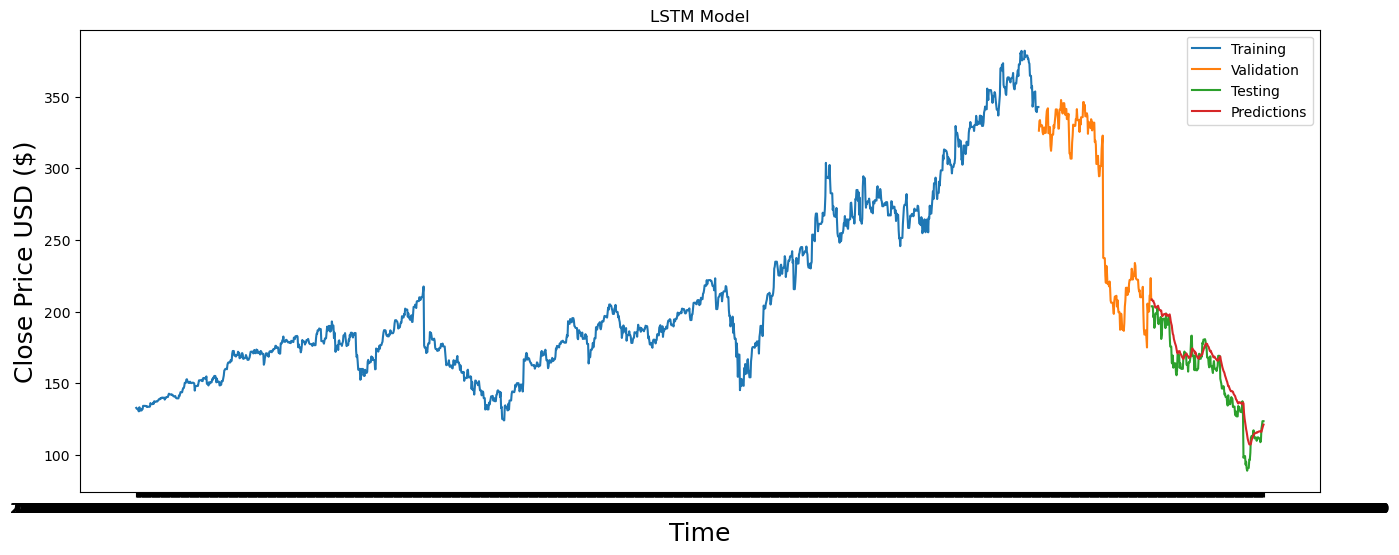

In [61]:
train = input_data[:train_valid_test_split.training_data_len]
valid = input_data[
    train_valid_test_split.training_data_len 
    : train_valid_test_split.training_data_len 
    + train_valid_test_split.validation_data_len
]
test = input_data[
    train_valid_test_split.training_data_len
    + train_valid_test_split.validation_data_len:
]
test['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('LSTM Model')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(test[['Close', 'Predictions']])
plt.legend(['Training', 'Validation', 'Testing', 'Predictions'], loc='upper right')
plt.show()